In [66]:
import sys
import datacube
import pandas as pd
import os
import xarray as xr

# Import external dea-notebooks functions using relative link to Scripts directory
sys.path.append('/g/data/r78/rt1527/dea-notebooks/10_Scripts')
import DEADataHandling, DEAPlotting


def load_sealevelx(ds, sealevelx_dir='/g/data/r78/sealevelx/data', spatial_agg=None):
    
    '''
    Takes an xarray dataset, and extracts modelled sea levels from the University of
    Western Australia 'sealevelx' Extreme Sea Levels product for each time step based on
    the spatial extent of the dataset.
    
    Last modified: April 2019
    Author: Robbi Bishop-Taylor
    
    Parameters
    ----------  
    ds : xarray Dataset
        A multi-dimensional xarray dataset with a `time` dimension for which to extract sea levels. 
        The dataset must include a `geobox` method to allow computing its spatial extent.
    sealevelx_dir : str, optional
        A path to the directory containing 'sealevelx' netCDF datasets containing hourly modelled
        sea levels, and an index file named 'AUSTRALIA_2km_SCHISM_points.csv'. These files are read 
        in based on the extent of the extent of the xarray dataset, and used to interpolate sea 
        levels at the exact timestamps of each acquisition time in `ds`.
    spatial_agg : str, optional
        By default, sea levels are returned for every coastal data point in the 'sealevelx' 
        dataset (spaced every 2km along the Australian coastline) that falls within the extent of
        `ds`. To summarise these values and return a single sea level for each timestep, provide one
        of the following options: `mean`, `median`, `prod`, `sum`, `std`, `var`.

    Returns
    -------
    sealevelx_pd  : pandas dataframe
        A pandas dataframe object with interpolated sea levels for each timestep in `ds`, and
        each coastal data point in the 'sealevelx' dataset (spaced every 2km along the Australian
        coastline). If an option was supplied to `spatial_agg`, the resulting dataframe will contain
        a single sea level for each timestep in `ds`.
    
    '''

    # Read in index linking IDs to lat/longs
    sealevelx_index_pd = pd.read_csv(f'{sealevelx_dir}/AUSTRALIA_2km_SCHISM_points.csv')

    # Identify coastal data points within dataset boundary
    bbox = ds.geobox.geographic_extent.boundingbox
    sealevelx_index_pd = sealevelx_index_pd.loc[(sealevelx_index_pd.X > bbox.left) & 
                                                (sealevelx_index_pd.X < bbox.right) &
                                                (sealevelx_index_pd.Y > bbox.bottom) &
                                                (sealevelx_index_pd.Y < bbox.top)]
    
    sealevelx_paths = sealevelx_index_pd.apply(lambda x: 
                                               f'{sealevelx_dir}/{int(x.ID):05d}_Data.nc', axis=1)
    sealevelx_paths = [file for file in sealevelx_paths if os.path.exists(file)]
    print(f'Extracting data for {len(sealevelx_paths)} coastal data points')    
    
    # Open all data as a dask xarray dataset
    all_nodes = xr.open_mfdataset(paths=sealevelx_paths, concat_dim='file').squeeze('coast_id')

    # Interpolate hourly results to get sea level estimates for exact acquisition time
    all_nodes = all_nodes.interp(time=ds.time.data.astype('M8[s]').astype('O').tolist())

    # Select only required columns
    all_nodes  = all_nodes[['time', 'id', 'node', 'latitude', 'longitude', 'sealevel']]

    # Re-index to give latitude, longitude and time dimensions
    sealevelx_ds = all_nodes.set_index({'file': ['latitude', 'longitude']}).unstack()   
    
    # Convert to pandas dataframe with time, latitude, longitude columns
    sealevelx_pd = sealevelx_ds.sealevel.to_dataframe().dropna()
    
    # If spatial aggregation is set, group by time and summarise
    if spatial_agg:
        
        sealevelx_pd = sealevelx_pd.groupby(level=0).agg(spatial_agg)   
    
    return sealevelx_pd 


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set up datacube query

In [4]:
# Create datacube instance
dc = datacube.Datacube(app='Tidal tagging')

# Create 'query' based on the longitudes, latitudes and time provided above
lon_min, lat_max = 140.75, -17.41
lon_max, lat_min = 140.87, -17.51

query = {'y': (lat_min, lat_max),
         'x': (lon_min, lon_max),
         'crs': 'EPSG:4326',
         'time': ('2003-10-01', '2008-12-31'),
         'output_crs': 'EPSG:3577',
         'resolution': (-25, 25)}

DEAPlotting.display_map(x=query['x'], y=query['y'], crs=query['crs'])

### Load in Landsat data

In [56]:
# Load in Landsat observations
landsat_ds = DEADataHandling.load_clearlandsat(dc=dc, query=query, 
                                               bands_of_interest=['red', 'green', 'blue'], 
                                               mask_pixel_quality=True) 

landsat_ds

Loading ls5
    Loading 182 filtered ls5 timesteps
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Skipping ls8; no valid data for query
Returning ls5 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


<xarray.Dataset>
Dimensions:    (time: 182, x: 540, y: 477)
Coordinates:
  * time       (time) datetime64[ns] 2003-10-09T00:12:45.500000 ... 2008-12-25T00:19:27.500000
  * y          (y) float64 -1.889e+06 -1.889e+06 ... -1.901e+06 -1.901e+06
  * x          (x) float64 9.297e+05 9.297e+05 9.297e+05 ... 9.431e+05 9.431e+05
Data variables:
    red        (time, y, x) float64 nan nan nan ... 1.582e+03 1.463e+03 1.74e+03
    green      (time, y, x) float64 nan nan nan ... 1.277e+03 1.616e+03
    blue       (time, y, x) float64 nan nan nan ... 1.138e+03 1.033e+03 1.3e+03
    data_perc  (time, y, x) float64 nan nan nan nan ... 0.2881 0.2881 0.2881
Attributes:
    crs:      EPSG:3577

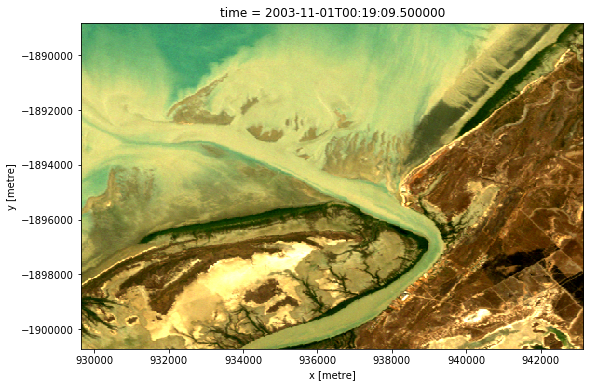

In [57]:
# Plot example
DEAPlotting.rgb(landsat_ds, index=2)

## Load WA sea level into xarray format
The following cells use the `load_sealevelx` function to extract sea level data for all coastal data points located within the extent of the xarray dataset `landsat_ds`. These sea levels can be aggregated to produce a single representative sea level height for each timestep in `landsat_ds`.

In [58]:
# Extract sea levels for every coastal data point within the extent of `landsat_ds`
sealevel_data = load_sealevelx(landsat_ds)
sealevel_data.head()

Extracting data for 12 coastal data points


sealevel
time                latitude   longitude           
2003-10-09 00:12:45 -17.497302 140.744830  401.7500
                    -17.485460 140.758226  419.9625
                    -17.476885 140.773673  412.1750
                    -17.474714 140.838337  406.0250
                    -17.472052 140.790920  410.6000

In [59]:
# Extract mean sea levels for every coastal data point within the extent of `landsat_ds`
sealevel_data = load_sealevelx(landsat_ds, spatial_agg='mean')
sealevel_data.head()

Extracting data for 12 coastal data points


,sealevel
time,
2003-10-09 00:12:45,407.635417
2003-10-25 00:12:58,450.057593
2003-11-01 00:19:09,-990.310208
2003-11-10 00:13:05,-703.326736
2003-11-17 00:19:26,-836.501065


In [60]:
# Extract median sea levels for every coastal data point within the extent of `landsat_ds`
sealevel_data = load_sealevelx(landsat_ds, spatial_agg='median')
sealevel_data.head()

Extracting data for 12 coastal data points


,sealevel
time,
2003-10-09 00:12:45,405.918750
2003-10-25 00:12:58,451.451667
2003-11-01 00:19:09,-990.737500
2003-11-10 00:13:05,-703.631250
2003-11-17 00:19:26,-837.208889


## Assign tide heights back into xarray dataset

In [62]:
landsat_ds['sealevel'] = xr.DataArray(sealevel_data.sealevel, [('time', landsat_ds.time)])
landsat_ds

<xarray.Dataset>
Dimensions:    (time: 182, x: 540, y: 477)
Coordinates:
  * time       (time) datetime64[ns] 2003-10-09T00:12:45.500000 ... 2008-12-25T00:19:27.500000
  * y          (y) float64 -1.889e+06 -1.889e+06 ... -1.901e+06 -1.901e+06
  * x          (x) float64 9.297e+05 9.297e+05 9.297e+05 ... 9.431e+05 9.431e+05
Data variables:
    red        (time, y, x) float64 nan nan nan ... 1.582e+03 1.463e+03 1.74e+03
    green      (time, y, x) float64 nan nan nan ... 1.277e+03 1.616e+03
    blue       (time, y, x) float64 nan nan nan ... 1.138e+03 1.033e+03 1.3e+03
    data_perc  (time, y, x) float64 nan nan nan nan ... 0.2881 0.2881 0.2881
    sealevel   (time) float64 405.9 451.5 -990.7 ... -464.8 -1.322e+03 -944.4
Attributes:
    crs:      EPSG:3577

#### Plot low and high tide images

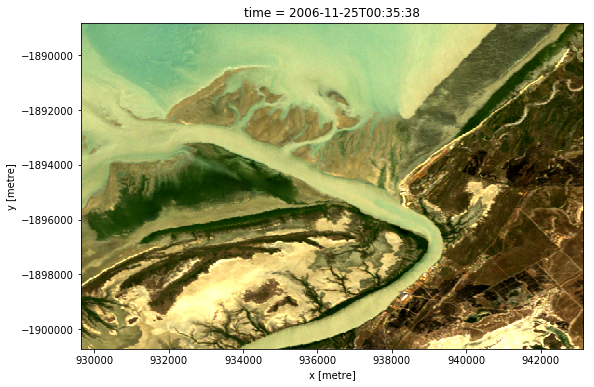

In [63]:
# Low tide image
DEAPlotting.rgb(landsat_ds.sortby('sealevel'), index=2)

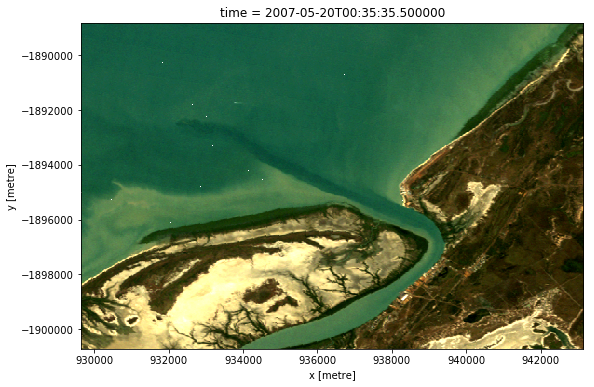

In [64]:
# High tide image
DEAPlotting.rgb(landsat_ds.sortby('sealevel'), index=-1)